# Load packages

In [1]:
#%reset

from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
from pathlib import Path
import os
from IPython.display import display
from ipyfilechooser import FileChooser
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer
from scipy.stats import zscore
from scipy.interpolate import interp1d
from itertools import groupby
from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer
from ephyviewer import InMemoryAnalogSignalSource
import ephyviewer
import json
import matplotlib.cm as cm
%matplotlib widget

from scipy.signal import find_peaks
from scipy.signal import chirp, find_peaks, peak_widths

# Choose OpenEphys folder

In [ ]:
#dpath = "//10.69.168.1/crnldata/forgetting"

try:
    %store -r dpath
except:
    print("data not in strore")
    dpath ="//10.69.168.1/crnldata/forgetting"


fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Select recording folder from OpenEphys</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

# stop when "continuous" & "events" folders appears

FileChooser(path='\\10.69.168.1\crnldata\forgetting', filename='', title='<b>Select recording folder from Open…

# Load data

In [28]:
folder = Path(dpath)

# Load metadata 
filepath = os.path.join(folder, f'structure.oebin')
with open(filepath) as f:
    metadata = json.load(f)
samplerate=metadata['continuous'][0]['sample_rate']  
print('sample rate = ', samplerate, 'Hz')
numchannel=metadata['continuous'][0]['num_channels']  
print(numchannel, 'channels recorded')
TTL_Opto_duration=[]

# Load TTLs
for file_path in folder.glob('**/TTL/timeStamps.npy'):
    print('TTL opto file = ', file_path)
    TTL_Opto_o = np.load(file_path)
    TTL_Opto_duration =[round(TTL_Opto_o[i+1] - TTL_Opto_o[i],3) for i in range(len(TTL_Opto_o) - 1)[::2]]
    TTL_Opto= TTL_Opto_o[::2] # remove the TTL for laser OFF, only keep TTL for laser ON. CAUTION /!/ works only if it started with a TTL for laser ON

    print(TTL_Opto.shape[0], 'opto stimulations')

# Load LFPs 
for file_path in folder.glob('**/continuous.dat'):
    print('LFPs data file = ', file_path)
    LFPs = np.fromfile(file_path, dtype="int16")
    All = LFPs.reshape(-1,numchannel)
    LFPs2 = np.fromfile(file_path, dtype="uint16")
    All2 = LFPs2.reshape(-1,numchannel)
    
# Load LFPs timestamps 
for file_path in folder.glob('**/continuous/*/timeStamps.npy'):
    print('LFPs timestamps file = ', file_path)
    LFPtimestamps = np.load(file_path)  

print(round(All.shape[0]/samplerate/60), 'min of recording')

sample rate =  10000.0 Hz
32 channels recorded
TTL opto file =  \\10.69.168.1\crnldata\forgetting\Carla\OpenEphysData\Rouge\RougeAHAD02_01_2025-02-28_09-04-38_EPSP50_ms_0to20ms\Record Node 101\experiment1\recording2\events\OE_FPGA_Acquisition_Board-100.Rhythm Data\TTL\timeStamps.npy
1420 opto stimulations
LFPs data file =  \\10.69.168.1\crnldata\forgetting\Carla\OpenEphysData\Rouge\RougeAHAD02_01_2025-02-28_09-04-38_EPSP50_ms_0to20ms\Record Node 101\experiment1\recording2\continuous\OE_FPGA_Acquisition_Board-100.Rhythm Data\continuous.dat
LFPs timestamps file =  \\10.69.168.1\crnldata\forgetting\Carla\OpenEphysData\Rouge\RougeAHAD02_01_2025-02-28_09-04-38_EPSP50_ms_0to20ms\Record Node 101\experiment1\recording2\continuous\OE_FPGA_Acquisition_Board-100.Rhythm Data\timeStamps.npy
50 min of recording


Select LFPs channels (to modify)

In [29]:
Channels = "//10.69.168.1/crnldata/forgetting/Carla/OpenEphysData/LFPChannels_perMice.xlsx"
mice=folder.parts[-5].split('_')[0] # TO MODIFY
print(mice)

allchannels = pd.read_excel(Channels)

#PFCch1=int(allchannels[mice][0].split('_')[0])
#PFCch2=int(allchannels[mice][0].split('_')[1])
CA1ch1=int(allchannels[mice][2].split('_')[0])
CA1ch2=int(allchannels[mice][2].split('_')[1])
S1ch1=int(allchannels[mice][1].split('_')[0])
S1ch2=int(allchannels[mice][1].split('_')[1])
EMGch1=int(allchannels[mice][3])
oPFCch1=int(allchannels[mice][4].split('_')[0])
oPFCch2=int(allchannels[mice][4].split('_')[1])
EnthCch1=int(allchannels[mice][5].split('_')[0])
EnthCch2=int(allchannels[mice][5].split('_')[1])
RHch1=int(allchannels[mice][6].split('_')[0])
RHch2=int(allchannels[mice][6].split('_')[1])

oPFC1  =  All[:, (oPFCch1)]
oPFC2  =  All[:, (oPFCch2)]
#PFC  =  All[:, (PFCch1)]-All[:, (PFCch2)] 
#CA1  =  All[:, (CA1ch1)]-All[:, (CA1ch2)]
#S1  =  All[:, (S1ch1)]-All[:, (S1ch2)] 
#EMG  =  All[:, (EMGch1)]
#oPFC  =  All[:, (oPFCch1)]
#EnthC  =  All[:, (EnthCch1)]-All[:, (EnthCch2)] 





Rouge


Check TTL durations (optional)

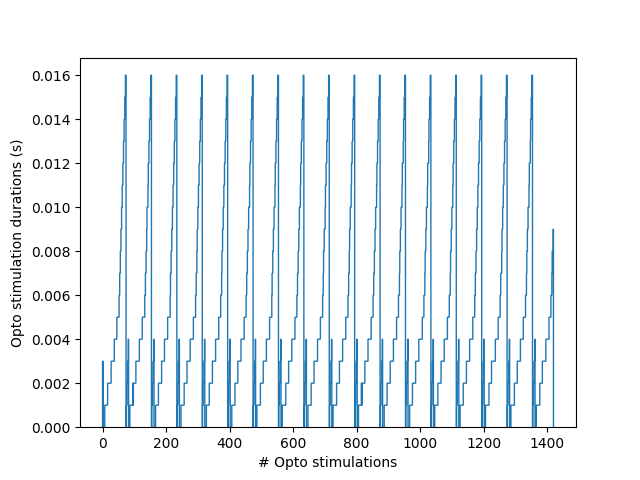

In [30]:
plt.close('all')
plt.stairs(TTL_Opto_duration)
plt.xlabel('# Opto stimulations')
plt.ylabel('Opto stimulation durations (s)')
plt.show()

# Get response of each LFPs channels

In [31]:
AllEPSPs=[]
for ttl in TTL_Opto:   
    idx = (np.abs(LFPtimestamps - ttl)).argmin() # find the closest LFP timestamps to the TTL
    AllEPSPs.append(All[idx-round(0.5*samplerate):idx+round(0.5*samplerate), :]) #500 ms before and after TTL

plt.close()
plt.figure(figsize=(10, 4))
time_axis = np.linspace(-0.5, 0.5, np.shape(AllEPSPs)[1]) 
mEPSPs=np.mean(AllEPSPs, axis=0)
colors = cm.rainbow(np.linspace(0, 1, np.shape(mEPSPs)[1]))
for i in np.arange(0,np.shape(AllEPSPs)[2]):
    plt.plot(time_axis, mEPSPs[:,i], label=f'Channel #{i}', color=colors[i])
plt.xlabel("Time (s)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=2)
plt.title('All opto stim')
plt.subplots_adjust(right=.5)
plt.show()


KeyboardInterrupt: 

# Get response for one LFP

Choose LFP

In [35]:
SelectedLFP=-oPFC1 # to change for PFC or S1 or etc
#SelectedLFP=-oPFC2 # to change for PFC or S1 or etc

In [36]:
nb_differentStim=len(np.unique(TTL_Opto_duration)) # how many different opto stim are performed in the arduino protocol (here a loop of 19 stim with different durations)
DurStim=np.unique(TTL_Opto_duration)*1000 # durations of each unique stim (from 1 ms to 20 ms with a step of 1)

halfdurEPSP=0.1 #sec
analyseWindow= 0.015 #sec

AllStim={}
for i, ttl  in enumerate(TTL_Opto):
    idx = (np.abs(LFPtimestamps - ttl)).argmin() # find the closest LFP timestamps to the TTL    
    if str(TTL_Opto_duration[i]*1000) in AllStim:
        AllStim[str(TTL_Opto_duration[i]*1000) ]=pd.concat([AllStim[str(TTL_Opto_duration[i]*1000) ],pd.DataFrame(SelectedLFP[idx-round(halfdurEPSP*samplerate):idx+round(halfdurEPSP*samplerate)])],axis=1)
    else:
        AllStim[str(TTL_Opto_duration[i]*1000) ]=pd.DataFrame(SelectedLFP[idx-round(halfdurEPSP*samplerate):idx+round(halfdurEPSP*samplerate)])
   
AllStim_sorted = dict(sorted(AllStim.items()))
meanAllStim= pd.DataFrame([np.mean(AllStim_sorted[key], axis=1) for key in AllStim_sorted.keys()]).T
meanAllStim= pd.DataFrame([meanAllStim[key]-np.mean(meanAllStim[key][int((halfdurEPSP*samplerate)-(halfdurEPSP*samplerate)):int(halfdurEPSP*samplerate)]) for key in meanAllStim.columns]).T
meanAllStim.columns=DurStim #convert columns names in ms


"""                         
Amplitude=meanAllStim[round(halfdurEPSP*samplerate):round((halfdurEPSP+analyseWindow)*samplerate)].max()-meanAllStim[round(halfdurEPSP*samplerate):round((halfdurEPSP+analyseWindow)*samplerate)].min()
Max=meanAllStim[round(halfdurEPSP*samplerate):round((halfdurEPSP+analyseWindow)*samplerate)].max()
HalfMaxWidth = [((np.abs(meanAllStim[i][meanAllStim[i][meanAllStim[i]==Max[i]].index[0]:] - Max[i]/2)).argmin() -round(halfdurEPSP*samplerate) + meanAllStim[i][meanAllStim[i]==Max[i]].index[0])/samplerate*1000 for i in meanAllStim.columns]
"""

Amplitude=[]
Max=[]
HalfMaxWidth=[]
for i in meanAllStim.columns:
    y=meanAllStim[i][round(halfdurEPSP*samplerate):round((halfdurEPSP+analyseWindow)*samplerate)]
    peaks, properties = signal.find_peaks(y, height=min(y), prominence=0)
    if len(peaks) > 0:
        widths, width_heights, left_ips, right_ips = signal.peak_widths(y, peaks, rel_height=0.5)
        biggest_peak_idx = np.argmax(properties["peak_heights"])
        biggest_peak = peaks[biggest_peak_idx]
        half_width = widths[biggest_peak_idx] / 2
        Amplitude.append(properties["prominences"][biggest_peak_idx])
        Max.append(properties["peak_heights"][biggest_peak_idx])
        HalfMaxWidth.append(half_width)
    else:
        Amplitude.append(np.nan)
        Max.append(np.nan)
        HalfMaxWidth.append(np.nan)


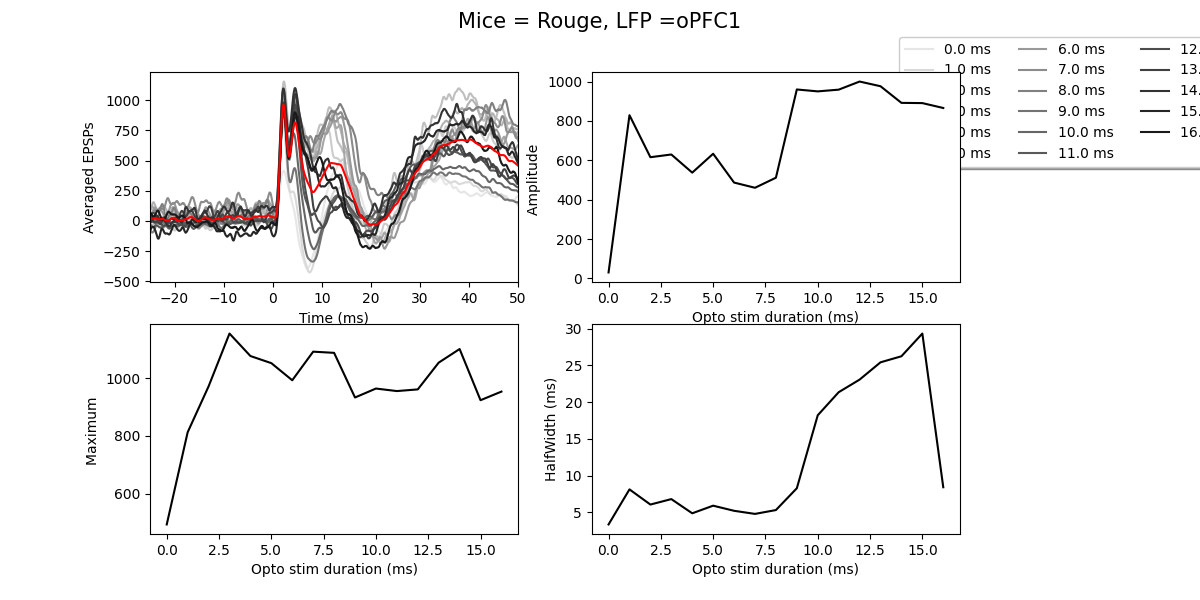

In [37]:
# Plot
plt.close()
fig, axs = plt.subplots(2,2, figsize=(12,6))
fig.suptitle(f'Mice = {mice}, LFP =oPFC1', fontsize=15) # Change to indicate where is located that LFP

time_axis = np.linspace(-halfdurEPSP*1000, halfdurEPSP*1000, meanAllStim.shape[0]) 
grey_shades = np.linspace(0.9, 0.1, len(meanAllStim.columns)) 
for i, col in enumerate(meanAllStim.columns):
    axs[0,0].plot(time_axis, meanAllStim[col], color=(grey_shades[i], grey_shades[i], grey_shades[i]), label=f'{round(col,4)} ms')
axs[0,0].plot(time_axis, np.mean(meanAllStim, axis= 1), color='red')
axs[0,0].set(xlabel="Time (ms)", ylabel="Averaged EPSPs")
#axs[0,0].set(ylim=(-750, 1000))
axs[0,0].set(xlim=(-25, 50))
axs[0,0].legend(loc='upper center', bbox_to_anchor=(2.5, 1.2),
          fancybox=True, shadow=True, ncol=3)

axs[0,1].plot(DurStim,Amplitude, 'k')
axs[0,1].set(xlabel="Opto stim duration (ms)", ylabel="Amplitude ")

axs[1,0].plot(DurStim,Max, 'k')
axs[1,0].set(xlabel="Opto stim duration (ms)", ylabel="Maximum ")

axs[1,1].plot(DurStim, HalfMaxWidth, 'k')
axs[1,1].set(xlabel="Opto stim duration (ms)", ylabel="HalfWidth (ms)")

plt.subplots_adjust(right=.8)  
plt.show()